# Project 1: Content Moderation and Toxicity Classification

## Using a RNN for Content Moderation and Toxicity Classification

#### Imports 

In [20]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from gpt4all import Embed4All
import torch
import torch.nn as nn
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow import keras
from keras.layers import LSTM,SimpleRNN, Dense, Embedding, Dropout, Bidirectional, Masking
from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from nltk.stem import WordNetLemmatizer
from gensim.models import KeyedVectors 
import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from nltk.stem.wordnet import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier, KerasRegressor
# from sklearn.model_selection import StratifiedKFold ,cross_val_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Loading and Preprocessing

#### Loading the Dataset into a pandas dataframe and displaying first few entries.

In [21]:
# Load your data
data_path = './train.csv'
df = pd.read_csv(data_path)
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


##### We extract the 'comment_text' column as our input (X) and the toxicity labels as our target (y). This separation allows us to focus on the textual data during preprocessing.


In [22]:
# Preprocessing
X = df['comment_text']
y = df.iloc[:, 2:]

### Loading Test Dataset and Preprocessing it

We filtered the test labels to exclude rows where the 'toxic' column has a value of -1.
The value -1 in this context likely indicates missing or irrelevant data.

In [23]:
# Read test data and test labels
fpath_val = './test.csv'
fpath_val_labels = './test_labels.csv'

test_data = pd.read_csv(fpath_val)
test_data_labels = pd.read_csv(fpath_val_labels)

# Merge test data and test labels
merged_test = pd.concat([test_data, test_data_labels], axis=1)

# Drop rows with -1 in any label column
merged_test = merged_test[(merged_test != -1).all(axis=1)]

merged_test.head(5)

,id,comment_text,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",00059ace3e3e9a53,0,0,0,0,0,0


## Tokenization Process

Tokenization is the process of converting the raw text into a sequence of integers, where each integer corresponds to a unique word in the corpus. We have set the following parameters:

- **Maximum Vocabulary Size (max_words):** Limits the vocabulary to the most frequent words. We have chosen 20,000 as it is a balance between capturing information(diverse vocabulary) and managing computational resources.
- **Sequence Length (maxlen):** Ensures uniform input size for the RNN. We have chosen 200 because it is suitable for capturing moderate-length comments and strikes a balance and is suitable for our text classification task.

#### Increasing `max_words`:

- **Positive Impact:**
  - May capture a more diverse vocabulary, potentially improving model understanding.

- **Consideration:**
  - Increased computational requirements.

#### Increasing `maxlen`:

- **Positive Impact:**
  - Allows the model to consider longer sequences, capturing more context.

- **Consideration:**
  - Longer sequences may require more memory during training.

Tokenization was essential for us to convert the variable-length textual data into a format suitable for training our RNN.The chosen parameters, such as max_words and maxlen, are designed to balance model complexity and efficiency.

### Tokenizer Class

The `Tokenizer` class from Keras is employed to vectorize the text corpus by turning each text into a sequence of integers.

#### Methods:

1. **fit_on_texts:**
   - Fits the tokenizer on the comment text.
   - Creates a vocabulary index based on word frequency.

2. **texts_to_sequences:**
   - Converts each comment text to a sequence of integers based on the tokenizer's vocabulary.

3. **pad_sequences:**
   - Ensures that all sequences have the same length by padding or truncating them.
   - Crucial for efficient batch processing in our RNN.


In [24]:
# Tokenization
max_words = 20000  #Maximum number of words to keep
maxlen = 200  #Maximum sequence length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=maxlen)

## Data Splitting: Training and Validation Sets

In the machine learning workflow, it's crucial to split our dataset into training and validation sets. This helps assess the model's performance on unseen data and avoid overfitting, where the model performs well on the training data but fails to generalize to new examples.
Here's how we've done it:

- **Random State (42):** The use of a fixed random state (42) ensures reproducibility. By setting the random state, we obtain the same split every time we run the code. This consistency is valuable for debugging, sharing, and comparing results.

- **Test Size (0.2):** We've allocated 20% of the data for validation, leaving 80% for training. Usually, the choice of the test size depends on the dataset and the desired balance between training and validation samples. A common practice is to use 80-20 or 70-30 splits.


In [25]:
# Splitting data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=0.2, random_state=42)

### Class Imbalances

#### Plotting the distribution of classes in training Data

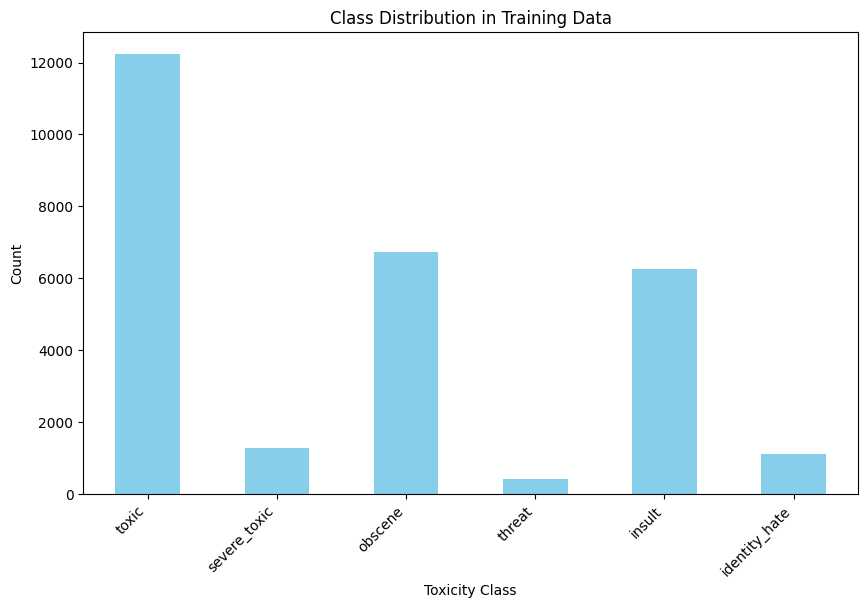

In [26]:
# Plotting class distribution
plt.figure(figsize=(10, 6))
y_train.sum().plot(kind='bar', color='skyblue')
plt.title('Class Distribution in Training Data')
plt.xlabel('Toxicity Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

### Interpreting the Class Distribution Graph

The bar chart visualizes the distribution of training samples across different classes. The height of each bar represents the quantity of samples for that specific class, where taller bars indicate more samples and shorter bars indicate fewer.

#### Class Imbalance

The chart tells us about a noticeable class imbalance within the dataset. The "toxic" class has the highest number of samples, followed by "insult", and "obscene". Conversely, the classes "severe toxic", "threat", and "identity hate" exhibit significantly fewer samples.

#### Implications for Model Training

The observed class imbalance has implications for training a predictive model on this dataset. While the model may perform well in detecting content labeled as "toxic", "insult", and "obscene" due to the abundance of training examples, it may face challenges in accurately predicting classes with fewer instances, such as "severe toxic", "threat", and "identity hate". We need careful consideration and potential mitigation strategies for addressing the imbalanced distribution during the model training process.

#### Calculating Class Weights for Imbalanced Classes

We have employed class weights during model training to give more importance to underrepresented classes, aiding the model in learning from minority samples. 

In the code cell below, each code line has corresponding comment as to what it is trying to achieve

In [27]:
# calculating the sum of each column in y_train.
label_counts = y_train.sum(axis=0) 
#label_counts captures the count of occurrences for each class in the training data. 
#Each element signifies the count of positive instances for a specific toxicity class.

total_samples = len(y_train) #holds the overall number of instances in the training data.

#computes class weights using a formula that considers the total number of samples and the count of positive instances for each class.
#The objective is to assign higher weights to underrepresented classes, facilitating improved learning from minority samples.
#The resulting class weights are stored in the class_weights variable.
class_weights = total_samples / (len(label_counts) * label_counts)


class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
#dictionary where keys (i) represent the index of each class,
# and values (weight) denote the computed class weights.

## RNN Model Training and Evaluation

Now, we delve into the design choices, model architecture, and evaluation metrics employed during the training of our Recurrent Neural Network (RNN).

### Model Architecture

- **Embedding Layer:** This is the first layer in the model, responsible for converting input text data into dense vectors of a fixed size (32 in this case). It learns a continuous representation of words based on their context in the dataset.

- **SimpleRNN Layer:** We employed SimpleRNN layer with 32 units, this layer incorporates recurrent connections, enabling the model to capture sequential patterns in the data. `return_sequences=False` indicates that only the output of the last time step is considered.

We experimented with different units and found out 32 was the optimal and balanced choice. Increasing it further led to increase in model complexity, training time, overfitting and thus reduced validation and testing accuracy.
Similiarly, increasing layers by introducing an LSTM and dropout layer increased model complexity and led to overfitting and drop in validation and testing accuracy.

- **Dense Layer:** The final Dense layer with 6 units (equal to the number of toxicity classes) uses a sigmoid activation function to produce binary outputs for each toxicity class.

### Model Compilation

- **Loss Function:** We chose Binary crossentropy as the loss function, as it suits such scenarios where multiple labels can be active at the same time. BCE loss assumes independence between classes, meaning the prediction for one class does not influence the prediction for another.

- **Optimizer:** We used Adam used as the optimizer. Adam adapts the learning rates of each parameter during training, offering a good balance between efficiency and performance.

- **Metrics:** We monitor training progress using loss and accuracy as the evaluation metric.

### Model Training

- **Epochs:** We trained our model for 2 epochs. We made this choice due to the balance between training time and achieving convergence. Monitoring validation performance helped us avoid overfitting
By experimentation, we observed that when we run for more epochs, there is overfitting as training accuracy increases and testing accuracy drops.

- **Class Weights:** We utilized `class_weight` parameter, incorporating the previously computed class weights (`class_weight_dict`). This addresses the class imbalance in the training data.


In [28]:
# Building the RNN model
model_rnn = Sequential()
model_rnn.add(Embedding(max_words, 32, input_length=maxlen))
model_rnn.add(SimpleRNN(32, return_sequences=False))  # SimpleRNN layer with 32 units
model_rnn.add(Dense(6, activation='sigmoid'))

model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the RNN model
model_rnn.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val),class_weight=class_weight_dict)

# Calculating training accuracy
train_loss, train_accuracy = model_rnn.evaluate(X_train, y_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")



Epoch 1/2
3990/3990 [==============================] - 220s 55ms/step - loss: 0.1986 - accuracy: 0.9680 - val_loss: 0.1352 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0673 - accuracy: 0.9760
Training Accuracy: 97.60%


### Model Evaluation

- **Metrics:** 

We used test f1-score as the metric for evaluation. Because in the case of class imbalance, where one class has significantly more instances than the other, accuracy might not be a suitable metric.
This is because a model can achieve high accuracy by simply predicting the majority class all the time, although we also made sure that it doesn't drop significantly

In [29]:

#Evaluating model on test set
X_test = merged_test['comment_text']
y_test = merged_test.iloc[:, 3:]

#Tokenization and Padding
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

#Using our trained model to predict on the test data
test_predictions = model_rnn.predict(X_test_pad)

threshold = 0.5

#Converting the test predictions to binary labels based on the threshold (as taught in class that probability greater than 0.5 is positive else negative)
binary_test_predictions = np.where(test_predictions > threshold, 1, 0)

#Calculating the accuracy manually using the binary predictions
correct_predictions = np.sum(np.all(binary_test_predictions == y_test.values, axis=1))
total_samples = len(y_test)
test_accuracy = correct_predictions / total_samples

#Printing the accuracy
print(f"Test Accuracy (Threshold > {threshold}): {test_accuracy * 100:.2f}%")

# Calculating the F1-score and Recall
test_report = classification_report(y_test, binary_test_predictions, target_names=y_test.columns)
print("Test Metrics:")
print(test_report)

2000/2000 [==============================] - 20s 10ms/step
Test Accuracy (Threshold > 0.5): 89.61%
Test Metrics:
               precision    recall  f1-score   support

        toxic       0.67      0.58      0.62      6090
 severe_toxic       0.22      0.05      0.09       367
      obscene       0.61      0.60      0.60      3691
       threat       0.05      0.03      0.03       211
       insult       0.56      0.50      0.53      3427
identity_hate       0.37      0.02      0.04       712

    micro avg       0.61      0.51      0.56     14498
    macro avg       0.41      0.30      0.32     14498
 weighted avg       0.59      0.51      0.54     14498
  samples avg       0.05      0.04      0.04     14498



## Interpretation of Results

## Overall Accuracy

The overall accuracy of the model on the test set is 89.61% which indicates that, on average, our model correctly predicts the toxicity labels for 89.61% of instances.

## Interpretation and Analysis

### Toxic Class

- **Precision:** 67%
- **Recall:** 58%

The model performs reasonably well in identifying toxic comments, but there is room for improvement in recall.

### Severe Toxic Class

- **Precision:** 22%
- **Recall:** 5%

The model struggles to correctly identify severe_toxic comments, with both precision and recall being low.

### Obscene Class

- **Precision:** 61%
- **Recall:** 60%

The model has good precision for obscene comments but misses some instances.

### Threat Class

- **Precision:** 5%
- **Recall:** 3%

The model performs poorly in both identifying actual threats and avoiding false positives.

### Insult Class

- **Precision:** 56%
- **Recall:** 50%

Similar to toxic, the model has moderate precision and recall for insults.

### Identity Hate Class

- **Precision:** 37%
- **Recall:** 2%

The model struggles to correctly identify identity_hate comments, with both precision and recall being low.

### Key Observations

### Imbalanced Classes

Some classes like threat and identity_hate and severe toxic, have low support, indicating imbalances. Class imbalance is impacting our model's ability to learn patterns for minority classes, although we have made adjustments to it by assigning weights to classess
Our model faces significant challenges in identifying instances related to severe toxicity, threat, and identity hate due to class imbalances. The dataset should have more training instances of these, and there should be less class imbalance to improve results.


### Testing our model on our example comments

We formulated some test comments of our own to check how good the predictions were :)

In [30]:
custom_sentence_list = ["Are you insane!","I will kill you nigga"]

for custom_sentence in custom_sentence_list:
    print(custom_sentence)
    # Preprocess the custom sentence using the same tokenizer
    custom_seq = tokenizer.texts_to_sequences([custom_sentence])
    custom_seq = pad_sequences(custom_seq, maxlen=200)

    # Use the trained model to predict on the custom sentence
    predictions = model_rnn.predict(custom_seq)

    # Print the predicted probabilities for each class
    # print(predictions)

    threshold = 0.5
    binary_predictions = np.where(predictions > threshold, 1, 0)
    print("toxic severe_toxic obscene threat insult	identity_hate")
    print(binary_predictions)

Are you insane!
1/1 [==============================] - 0s 40ms/step
toxic severe_toxic obscene threat insult	identity_hate
[[0 0 0 0 0 0]]
I will kill you nigga
1/1 [==============================] - 0s 36ms/step
toxic severe_toxic obscene threat insult	identity_hate
[[1 0 1 0 1 1]]
